Initializing Analyzer...


C:\Users\oness\AppData\Roaming\Python\Python313\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\oness\AppData\Local\Temp\ipykernel_21012\1074610738.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates_df = self.df.groupby('subject#').apply(lambda x: (x['total_UPDRS'].max() - x['total_UPDRS'].min()) / (x['test_time'].max() - x['test_time'].min()) if (x['test_time'].max() - x['test_time'].min()) > 0 else 0).reset_index(name='rate')
C:\Users\oness\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but Stand

✅ Analyzer is ready.

--- Predictive Forecast Report ---
Input Data: [22, 25, 26, 29, 32]
Context: Age≈65, Sex=Male (found 10 matches)
------------------------------------
Predicted Cohort: Fast Progressor
Prediction Confidence: 100.0%
Closest Single Match: Patient #17
------------------------------------


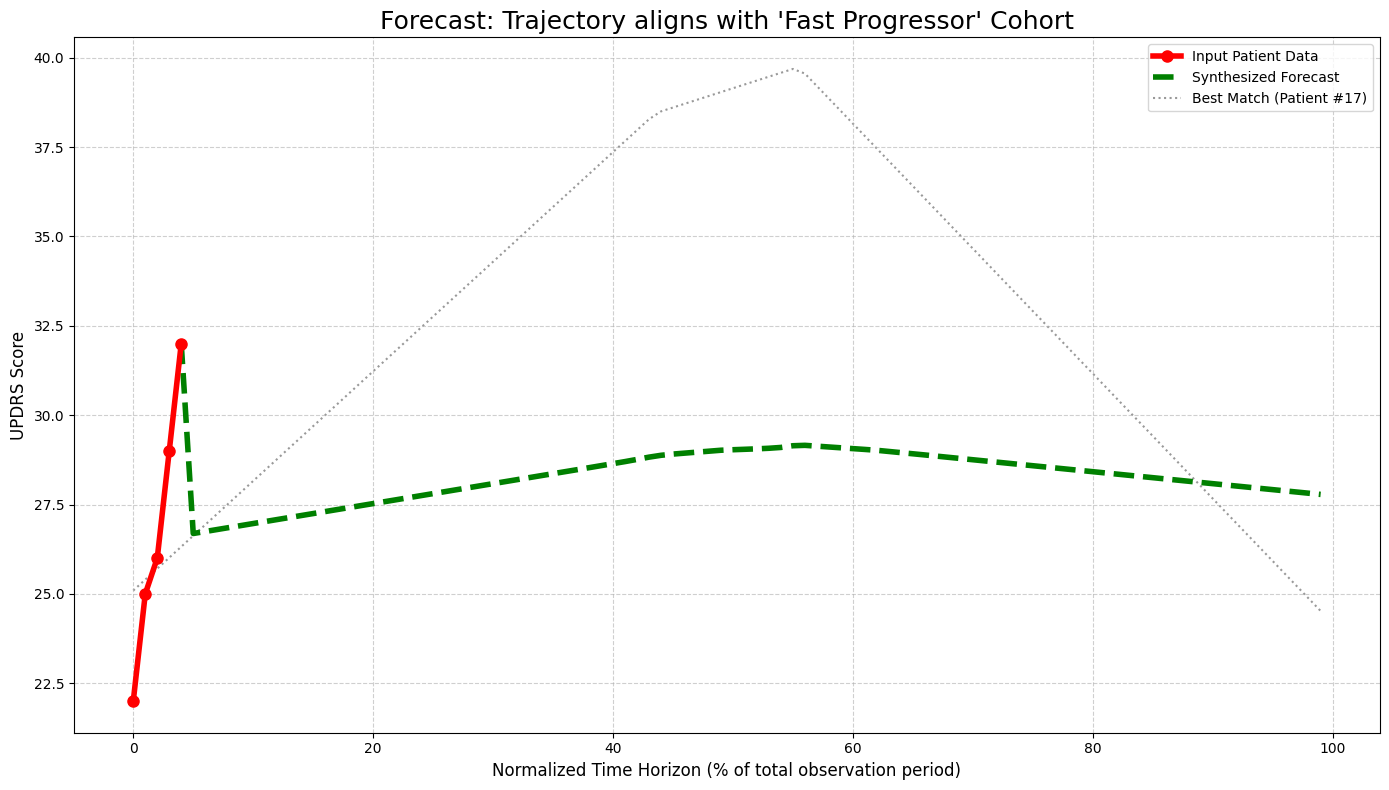

In [1]:
# ==============================================================================
# PARKINSON'S SYMPTOM PROGRESSION ANALYZER - REFACTORED ENGINE
# Author: Onessa Crispeyn
#
# Description:
# This refactored version encapsulates the entire analysis pipeline within a
# reusable `ParkinsonsAnalyzer` class. It separates the core logic from the
# demonstration, making the code cleaner, more modular, and easier to maintain
# or integrate into other applications like a web server.
# ==============================================================================

# --- Part 1: Imports and Configuration ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from dtaidistance import dtw

# Centralized configuration for easy tweaking of model parameters
CONFIG = {
    "data_path": './parkinsons_updrs.data',
    "interpolation_points": 100,
    "n_clusters": 2,
    "k_matches": 10,
    "age_window": 5,
    "random_state": 42
}

class ParkinsonsAnalyzer:
    """A class to encapsulate the entire Parkinson's analysis pipeline."""

    def __init__(self, config):
        """
        Initializes the analyzer by loading data, training models, and preparing assets.
        This heavy lifting is done only once when the class is instantiated.
        """
        print("Initializing Analyzer...")
        self.config = config
        self.df = self._load_and_preprocess_data(config["data_path"])
        self.all_trajectories = self._standardize_all_trajectories(self.df)
        
        # Train the cohort discovery model
        self._discover_cohorts()
        
        # Prepare a global scaler for consistent scaling of new data
        self.global_scaler = StandardScaler().fit(self.df[['total_UPDRS']])
        print("✅ Analyzer is ready.")

    def _load_and_preprocess_data(self, path):
        """Loads and cleans the raw Parkinson's data."""
        column_names = [
            'subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)',
            'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
            'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
        ]
        df = pd.read_csv(path, names=column_names)
        df = df[['subject#', 'age', 'sex', 'test_time', 'total_UPDRS']]
        df[['total_UPDRS', 'test_time', 'age']] = df[['total_UPDRS', 'test_time', 'age']].apply(pd.to_numeric, errors='coerce')
        df.dropna(inplace=True)
        return df

    def _standardize_all_trajectories(self, df):
        """Interpolates all patient trajectories to a standard length."""
        def normalize_and_interpolate(patient_df):
            if len(patient_df) < 2: return None
            min_time, max_time = patient_df['test_time'].min(), patient_df['test_time'].max()
            if max_time == min_time: return None
            time_normalized = (patient_df['test_time'] - min_time) / (max_time - min_time)
            interp_func = interp1d(time_normalized, patient_df['total_UPDRS'], kind='linear', fill_value="extrapolate")
            return interp_func(np.linspace(0, 1, self.config["interpolation_points"]))

        all_trajectories = {sid: normalize_and_interpolate(pdf) for sid, pdf in df.groupby('subject#')}
        return {sid: traj for sid, traj in all_trajectories.items() if traj is not None and not np.isnan(traj).any()}

    def _discover_cohorts(self):
        """Uses K-Means clustering to discover and label patient cohorts."""
        subject_ids = list(self.all_trajectories.keys())
        trajectory_matrix = np.array(list(self.all_trajectories.values()))
        
        scaler = StandardScaler()
        scaled_trajectories = scaler.fit_transform(trajectory_matrix)
        
        kmeans = KMeans(n_clusters=self.config["n_clusters"], random_state=self.config["random_state"], n_init=10)
        clusters = kmeans.fit_predict(scaled_trajectories)
        
        cohort_df = pd.DataFrame({'subject#': subject_ids, 'cluster': clusters})
        rates_df = self.df.groupby('subject#').apply(lambda x: (x['total_UPDRS'].max() - x['total_UPDRS'].min()) / (x['test_time'].max() - x['test_time'].min()) if (x['test_time'].max() - x['test_time'].min()) > 0 else 0).reset_index(name='rate')
        cohort_df = pd.merge(cohort_df, rates_df, on='subject#')
        
        cluster_avg_rates = cohort_df.groupby('cluster')['rate'].mean()
        fast_cluster_id = cluster_avg_rates.idxmax()
        cohort_df['cohort'] = np.where(cohort_df['cluster'] == fast_cluster_id, 'Fast Progressor', 'Slow Progressor')
        
        # Merge cohort info back into the main dataframe
        self.df = pd.merge(self.df, cohort_df[['subject#', 'cohort']], on='subject#')

    def _find_top_k_matches(self, new_patient_series, patient_age, patient_sex):
        """Finds top matches by comparing the input series to historical starting segments."""
        input_series_scaled = self.global_scaler.transform(np.array(new_patient_series).reshape(-1, 1))
        input_len = len(input_series_scaled)

        target_df = self.df[self.df['age'].between(patient_age - self.config["age_window"], patient_age + self.config["age_window"]) & (self.df['sex'] == patient_sex)]
        if len(target_df['subject#'].unique()) < self.config["k_matches"]:
            target_df = self.df # Fallback to all data if context filter is too restrictive

        all_matches = []
        for sid in target_df['subject#'].unique():
            if sid in self.all_trajectories:
                historical_traj = self.all_trajectories[sid]
                historical_traj_scaled = self.global_scaler.transform(historical_traj.reshape(-1, 1))
                comparison_segment = historical_traj_scaled[:input_len]
                dist = dtw.distance(input_series_scaled, comparison_segment)
                all_matches.append({
                    "match_id": sid, "distance": dist,
                    "cohort": target_df[target_df['subject#'] == sid]['cohort'].iloc[0],
                    "full_trajectory": historical_traj
                })
        
        return sorted(all_matches, key=lambda x: x['distance'])[:self.config["k_matches"]]

    def _generate_weighted_forecast(self, top_matches, input_series_len):
        """Generates a forecast from a weighted average of the top matches."""
        distances = np.array([match['distance'] for match in top_matches])
        future_trajectories = np.array([match['full_trajectory'][input_series_len:] for match in top_matches])
        weights = 1 / (distances + 1e-9)
        normalized_weights = weights / np.sum(weights)
        forecast = np.average(future_trajectories, axis=0, weights=normalized_weights)
        
        cohort_weights = {}
        for match, weight in zip(top_matches, normalized_weights):
            cohort_weights[match['cohort']] = cohort_weights.get(match['cohort'], 0) + weight
        predicted_cohort = max(cohort_weights, key=cohort_weights.get)
        confidence = (cohort_weights[predicted_cohort] / sum(cohort_weights.values())) * 100
        return forecast, predicted_cohort, confidence

    def predict(self, new_patient_series, patient_age, patient_sex):
        """
        The main public method. Takes new patient data and returns a full analysis.
        """
        if len(new_patient_series) < 2:
            return {"error": "Input series must have at least 2 data points."}
            
        top_matches = self._find_top_k_matches(new_patient_series, patient_age, patient_sex)
        if not top_matches:
            return {"error": "Could not find any suitable matches for the given patient context."}
            
        forecast, cohort, confidence = self._generate_weighted_forecast(top_matches, len(new_patient_series))
        
        return {
            "input_data": new_patient_series,
            "forecast": forecast,
            "predicted_cohort": cohort,
            "confidence": confidence,
            "best_match": top_matches[0],
            "top_matches_count": len(top_matches)
        }

# --- Part 7: Demonstration (Separated from the core logic) ---

def plot_forecast(results):
    """Visualizes the analysis results."""
    input_data = results['input_data']
    input_len = len(input_data)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    x_axis_full = np.arange(CONFIG["interpolation_points"])
    x_axis_input = x_axis_full[:input_len]
    x_axis_forecast = x_axis_full[input_len-1:]

    ax.plot(x_axis_input, input_data, label='Input Patient Data', color='red', marker='o', markersize=8, linewidth=4, zorder=10)
    
    stitched_forecast_y = np.concatenate(([input_data[-1]], results['forecast']))
    ax.plot(x_axis_forecast, stitched_forecast_y, color='green', linewidth=4, linestyle='--', label='Synthesized Forecast')

    best_match_traj = results['best_match']['full_trajectory']
    ax.plot(x_axis_full, best_match_traj, label=f'Best Match (Patient #{results["best_match"]["match_id"]})', 
            linestyle=':', alpha=0.8, color='gray', zorder=-1)
    
    ax.set_title(f"Forecast: Trajectory aligns with '{results['predicted_cohort']}' Cohort", fontsize=18)
    ax.set_xlabel('Normalized Time Horizon (% of total observation period)', fontsize=12)
    ax.set_ylabel('UPDRS Score', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def run_demonstration():
    """Example of how to use the ParkinsonsAnalyzer class."""
    # This only runs once, creating a reusable analyzer instance
    analyzer = ParkinsonsAnalyzer(CONFIG)
    
    # Now we can run predictions as many times as we want
    test_patient_data = [22, 25, 26, 29, 32]
    results = analyzer.predict(new_patient_series=test_patient_data, patient_age=65, patient_sex=0)

    if "error" in results:
        print(f"\nAnalysis Error: {results['error']}")
    else:
        print("\n--- Predictive Forecast Report ---")
        print(f"Input Data: {results['input_data']}")
        print(f"Context: Age≈65, Sex=Male (found {results['top_matches_count']} matches)")
        print("------------------------------------")
        print(f"Predicted Cohort: {results['predicted_cohort']}")
        print(f"Prediction Confidence: {results['confidence']:.1f}%")
        print(f"Closest Single Match: Patient #{results['best_match']['match_id']}")
        print("------------------------------------")
        
        plot_forecast(results)

if __name__ == '__main__':
    run_demonstration()